# Magic: the Gathering Recommender System
___

##### Problem Statement:  
I will use data on Magic: the Gathering cards to build a content-based recommender system that suggests similar cards in order to improve card selection during the deck building process.

##### Outline:  
1. Gathering Data  
    a. The data can be gathered from Scryfall's bulk data section which has every card as a json file
2. Cleaning Data  
    a. There is a lot of unnecessary data that I can drop  
    b. Extract the nested json objects
3. EDA
4. Recommender System  
    a. Content-Based Recommender  
    b. Cosine similarity
5. Stretch Goals  
    a. Keep a running tally and rating system for a user-based collaborative recommender

##### Risks and Assumptions:  
One risk is that the data comes in the form of nested json objects which will need to be formatted in a way I can use it.  
I am also limiting the scope of the data to only look at unique cards. It can be a stretch goal to take into account any alternate printings  
Another potential issue is dealing with how the recommender system will actually recommend cards. For example, if a user enters 'Prized Amalgam' will they be recommended other 3 mana 3/3s in U/B or will/should it recommend cards that would work well with 'Prized Amalgam' like 'Bloodghast' or 'Narcomeba'

##### Data Sources:  
[Scryfall Bulk Data](https://scryfall.com/docs/api/bulk-data)  
[Scryfall Default Cards](https://archive.scryfall.com/json/scryfall-default-cards.json)

## 01 - Cleaning
___

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

from nltk.tokenize import RegexpTokenizer

pd.options.display.max_columns = 35

In [2]:
df = pd.read_json('../Data/scryfall-oracle-cards.json')

In [3]:
df.head()

,object,id,oracle_id,multiverse_ids,mtgo_id,mtgo_foil_id,tcgplayer_id,name,lang,released_at,uri,scryfall_uri,layout,highres_image,image_uris,mana_cost,cmc,...,story_spotlight,edhrec_rank,related_uris,preview,power,toughness,arena_id,watermark,promo_types,all_parts,frame_effects,card_faces,life_modifier,hand_modifier,loyalty,color_indicator,variation_of
0,card,86bf43b1-8d4e-4759-bb2d-0b2e03ba7012,0004ebd0-dfd6-4276-b4a6-de0003e94237,[15862],15870.0,15871.0,3094.0,Static Orb,en,2001-04-11,https://api.scryfall.com/cards/86bf43b1-8d4e-4...,https://scryfall.com/card/7ed/319/static-orb?u...,normal,True,{'small': 'https://img.scryfall.com/cards/smal...,{3},3.0,...,False,1660.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,7050735c-b232-47a6-a342-01795bfd0d46,0006faf6-7a61-426c-9034-579f2cfcfa83,[370780],49283.0,49284.0,69965.0,Sensory Deprivation,en,2013-07-19,https://api.scryfall.com/cards/7050735c-b232-4...,https://scryfall.com/card/m14/71/sensory-depri...,normal,True,{'small': 'https://img.scryfall.com/cards/smal...,{U},1.0,...,False,17172.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,card,e718b21b-46d1-4844-985c-52745657b1ac,0007c283-5b7a-4c00-9ca1-b455c8dff8c3,[470580],77122.0,NaN,196536.0,Road of Return,en,2019-08-23,https://api.scryfall.com/cards/e718b21b-46d1-4...,https://scryfall.com/card/c19/34/road-of-retur...,normal,True,{'small': 'https://img.scryfall.com/cards/smal...,{G}{G},2.0,...,False,5184.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,"{'source': 'Magicshibby', 'source_uri': 'https...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,card,036ef8c9-72ac-46ce-af07-83b79d736538,000d5588-5a4c-434e-988d-396632ade42c,[83282],22609.0,22610.0,12835.0,Storm Crow,en,2005-07-29,https://api.scryfall.com/cards/036ef8c9-72ac-4...,https://scryfall.com/card/9ed/100/storm-crow?u...,normal,True,{'small': 'https://img.scryfall.com/cards/smal...,{1}{U},2.0,...,False,10016.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,card,b125d1e7-5d9b-4997-88b0-71bdfc19c6f2,000e5d65-96c3-498b-bd01-72b1a1991850,[12380],12637.0,12638.0,6412.0,Walking Sponge,en,1999-02-15,https://api.scryfall.com/cards/b125d1e7-5d9b-4...,https://scryfall.com/card/ulg/47/walking-spong...,normal,True,{'small': 'https://img.scryfall.com/cards/smal...,{1}{U},2.0,...,False,15762.0,{'gatherer': 'https://gatherer.wizards.com/Pag...,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(20782, 68)

In [5]:
df.columns

Index(['object', 'id', 'oracle_id', 'multiverse_ids', 'mtgo_id',
       'mtgo_foil_id', 'tcgplayer_id', 'name', 'lang', 'released_at', 'uri',
       'scryfall_uri', 'layout', 'highres_image', 'image_uris', 'mana_cost',
       'cmc', 'type_line', 'oracle_text', 'colors', 'color_identity',
       'legalities', 'games', 'reserved', 'foil', 'nonfoil', 'oversized',
       'promo', 'reprint', 'variation', 'set', 'set_name', 'set_type',
       'set_uri', 'set_search_uri', 'scryfall_set_uri', 'rulings_uri',
       'prints_search_uri', 'collector_number', 'digital', 'rarity',
       'flavor_text', 'card_back_id', 'artist', 'artist_ids',
       'illustration_id', 'border_color', 'frame', 'full_art', 'textless',
       'booster', 'story_spotlight', 'edhrec_rank', 'related_uris', 'preview',
       'power', 'toughness', 'arena_id', 'watermark', 'promo_types',
       'all_parts', 'frame_effects', 'card_faces', 'life_modifier',
       'hand_modifier', 'loyalty', 'color_indicator', 'variation_of'],
  

___
### Drop unneeded columns

In [6]:
unneeded = ['id', 'oracle_id', 'multiverse_ids', 'tcgplayer_id', 'uri', 'scryfall_uri', 'image_uris', 
            'highres_image', 'games', 'set_uri', 'set_search_uri',  'scryfall_set_uri', 'rulings_uri', 
            'prints_search_uri', 'collector_number', 'card_back_id', 'artist_ids', 'illustration_id', 
            'story_spotlight', 'related_uris', 'preview', 'arena_id', 'all_parts', 'mtgo_id', 'variation_of',
            'color_indicator', 'mtgo_foil_id', 'life_modifier', 'hand_modifier', 'frame_effects', 'flavor_text',
            'watermark', 'lang', 'released_at', 'reserved', 'foil', 'nonfoil', 'promo', 'reprint', 'variation',
            'artist', 'frame', 'full_art', 'textless', 'booster', 'promo_types']
df = df.drop(columns=unneeded)

In [7]:
df.head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,oversized,set,set_name,set_type,digital,rarity,border_color,edhrec_rank,power,toughness,card_faces,loyalty
0,card,Static Orb,normal,{3},3.0,Artifact,"As long as Static Orb is untapped, players can...",[],[],"{'standard': 'not_legal', 'future': 'not_legal...",False,7ed,Seventh Edition,core,False,rare,white,1660.0,NaN,NaN,NaN,NaN
1,card,Sensory Deprivation,normal,{U},1.0,Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",False,m14,Magic 2014,core,False,common,black,17172.0,NaN,NaN,NaN,NaN
2,card,Road of Return,normal,{G}{G},2.0,Sorcery,Choose one —\n• Return target permanent card f...,[G],[G],"{'standard': 'not_legal', 'future': 'not_legal...",False,c19,Commander 2019,commander,False,rare,black,5184.0,NaN,NaN,NaN,NaN
3,card,Storm Crow,normal,{1}{U},2.0,Creature — Bird,Flying (This creature can't be blocked except ...,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",False,9ed,Ninth Edition,core,False,common,white,10016.0,1,2,NaN,NaN
4,card,Walking Sponge,normal,{1}{U},2.0,Creature — Sponge,{T}: Target creature loses your choice of flyi...,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",False,ulg,Urza's Legacy,expansion,False,uncommon,black,15762.0,1,1,NaN,NaN


In [8]:
df.columns

Index(['object', 'name', 'layout', 'mana_cost', 'cmc', 'type_line',
       'oracle_text', 'colors', 'color_identity', 'legalities', 'oversized',
       'set', 'set_name', 'set_type', 'digital', 'rarity', 'border_color',
       'edhrec_rank', 'power', 'toughness', 'card_faces', 'loyalty'],
      dtype='object')

I also want to drop any digital cards because I want the recommender to only look at physical cards

In [9]:
df = df.drop(df[df['digital'] == True].index)

Also drop oversized cards

In [10]:
df = df.drop(df[df['oversized'] == True].index)

In [11]:
df = df.drop(columns=['oversized', 'digital'])

___
### check for nulls

In [12]:
df.isnull().sum()

object                0
name                  0
layout                0
mana_cost           193
cmc                   0
type_line             0
oracle_text         332
colors              193
color_identity        0
legalities            0
set                   0
set_name              0
set_type              0
rarity                0
border_color          0
edhrec_rank        1317
power              9074
toughness          9074
card_faces        19032
loyalty           19169
dtype: int64

In [13]:
df.shape

(19364, 20)

Art Series cards only existed in the modern horrizon set and are not actual cards, so we should drop them from our data set

In [14]:
df = df.drop(df[df['layout'] == 'art_series'].index)

In [15]:
# edhrec_rank nulls should be 0. meaning no decks on edhrec play the card
df['edhrec_rank'] = df['edhrec_rank'].fillna(0)

In [16]:
# drop all the cards from the joke sets, because they are not legal in any format
df = df.drop(df[(df['set'] == 'unh') | (df['set'] == 'ugl') | (df['set'] == 'ust')].index)

In [17]:
df['border_color'].value_counts()

black         18076
white           675
gold             72
silver           24
borderless        1
Name: border_color, dtype: int64

In [18]:
# drop any remaining gold or silver bordered cards because those are not legal either
df = df.drop(df.loc[(df['border_color'] == 'gold') | (df['border_color'] == 'silver')].index)

### drop tokens and non-legal cards

In [19]:
df['layout'].value_counts()

normal                18034
token                   345
transform               104
split                    86
emblem                   51
double_faced_token       33
adventure                30
leveler                  25
flip                     20
saga                     14
meld                      9
vanguard                  1
Name: layout, dtype: int64

In [20]:
non_cards_index = df[(df['layout'] == 'double_faced_token') | (df['layout'] == 'token') | 
                             (df['layout'] == 'vanguard') | (df['layout'] == 'emblem')].index

In [21]:
df = df.drop(non_cards_index)
df = df.drop(df[df['set_type'] == 'token'].index)
df.shape

(18268, 20)

In [22]:
df['set_type'].value_counts()

expansion           10862
funny                1819
core                 1739
commander            1316
masters               900
draft_innovation      609
duel_deck             581
starter               248
planechase            100
archenemy              79
memorabilia            10
box                     5
Name: set_type, dtype: int64

In [23]:
df.loc[df['set_type'] == 'funny']['set'].value_counts()

mb1      1694
cmb1      120
htr17       3
hho         2
Name: set, dtype: int64

In [24]:
# the sets cmb1, htr17, and hho are not legal in any format so let's drop them
joke_cards_index = df.loc[(df['set'] == 'hho') | (df['set'] == 'htr17') | (df['set'] == 'cmb1')].index
df = df.drop(joke_cards_index)

In [25]:
# cards with the memorabilia set_type are also not legal in any format, so let's drop those as well.
non_legal_index = df.loc[df['set_type'] == 'memorabilia'].index
df = df.drop(non_legal_index)

In [26]:
# conspiracy cards are also not legal in any format
conspiracy_index = df.loc[df['type_line'] == 'Conspiracy'].index
df = df.drop(conspiracy_index)

In [27]:
# now that we've cleaned up the df a little, we can drop some more extraneous columns
df = df.drop(columns=['set', 'set_name', 'set_type', 'border_color'])

In [28]:
df.isnull().sum()

object                0
name                  0
layout                0
mana_cost           104
cmc                   0
type_line             0
oracle_text         237
colors              104
color_identity        0
legalities            0
rarity                0
edhrec_rank           0
power              8436
toughness          8436
card_faces        17871
loyalty           17921
dtype: int64

In [29]:
df[df['colors'].isnull()]['layout'].value_counts()

transform    104
Name: layout, dtype: int64

In [30]:
df[df['mana_cost'].isnull()]['layout'].value_counts()

transform    104
Name: layout, dtype: int64

In [31]:
df[df['oracle_text'].isnull()]['layout'].value_counts()

transform    104
split         83
adventure     30
flip          20
Name: layout, dtype: int64

In [32]:
df = df.reset_index(drop=True)
df.head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty
0,card,Static Orb,normal,{3},3.0,Artifact,"As long as Static Orb is untapped, players can...",[],[],"{'standard': 'not_legal', 'future': 'not_legal...",rare,1660.0,NaN,NaN,NaN,NaN
1,card,Sensory Deprivation,normal,{U},1.0,Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",common,17172.0,NaN,NaN,NaN,NaN
2,card,Road of Return,normal,{G}{G},2.0,Sorcery,Choose one —\n• Return target permanent card f...,[G],[G],"{'standard': 'not_legal', 'future': 'not_legal...",rare,5184.0,NaN,NaN,NaN,NaN
3,card,Storm Crow,normal,{1}{U},2.0,Creature — Bird,Flying (This creature can't be blocked except ...,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",common,10016.0,1,2,NaN,NaN
4,card,Walking Sponge,normal,{1}{U},2.0,Creature — Sponge,{T}: Target creature loses your choice of flyi...,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,15762.0,1,1,NaN,NaN


___
From here I'd like to deal with the dual cards (transform, split, adventure, and flip cards).  

For flip and transform cards I want to keep the names the same because I want the recommender to recommend the whole card, not just one half of it.  

First let's deal with the transform cards.  
Since transform cards can have different values on each side, I'm going to make another column that keeps track of the transformed side's values. For example, the entry for Delver of Secrets // Insectile Aberration will be one row however will have a power column that will be Delver of Secrets's power and another column that will be Insectile Aberration's power. Same thing for other values on the card

In [33]:
trans_df = df.loc[df['layout'] == 'transform']
trans_df.head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty
193,card,Ulvenwald Captive // Ulvenwald Abomination,transform,NaN,2.0,Creature — Werewolf Horror // Creature — Eldra...,NaN,NaN,[G],"{'standard': 'not_legal', 'future': 'not_legal...",common,4624.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Ulvenwald Ca...",NaN
381,card,"Westvale Abbey // Ormendahl, Profane Prince",transform,NaN,0.0,Land // Legendary Creature — Demon,NaN,NaN,[B],"{'standard': 'not_legal', 'future': 'not_legal...",rare,364.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Westvale Abb...",NaN
603,card,Extricator of Sin // Extricator of Flesh,transform,NaN,3.0,Creature — Human Cleric // Creature — Eldrazi ...,NaN,NaN,[W],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,11026.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Extricator o...",NaN
783,card,Treasure Map // Treasure Cove,transform,NaN,2.0,Artifact // Land,NaN,NaN,[],"{'standard': 'not_legal', 'future': 'not_legal...",rare,1469.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Treasure Map...",NaN
926,card,"Ulrich of the Krallenhorde // Ulrich, Uncontes...",transform,NaN,5.0,Legendary Creature — Human Werewolf // Legenda...,NaN,NaN,"[G, R]","{'standard': 'not_legal', 'future': 'not_legal...",mythic,5342.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Ulrich of th...",NaN


In [34]:
# set up empty lists to fill
# first set of lists are for the front half
mana_cost_list = []
oracle_text_list = []
colors_list = []
power_list = []
toughness_list = []
loyalty_list = []
card_type_list = []

# second set of lists are for the back half. We don't need mana cost for transformed sides because they are treated
# as the same as the front side
oracle_text_back_list = []
colors_back_list = []
power_back_list = []
toughness_back_list = []
loyalty_back_list = []
card_type_back_list = []

# iterate through our list of transform cards
for index in trans_df.index:
    
    # Front half of the cards
    mana_cost_list.append(trans_df.loc[index, 'card_faces'][0]['mana_cost'])
    oracle_text_list.append(trans_df.loc[index, 'card_faces'][0]['oracle_text'])
    colors_list.append(trans_df.loc[index, 'card_faces'][0]['colors'])
    # doing some try/excepts becuase not all cards have power, toughness, or loyalty
    try:
        power_list.append(trans_df.loc[index, 'card_faces'][0]['power'])
    except:
        power_list.append('NONE')
    try:
        toughness_list.append(trans_df.loc[index, 'card_faces'][0]['toughness'])
    except:
        toughness_list.append('NONE')
    try:
        loyalty_list.append(trans_df.loc[index, 'card_faces'][0]['loyalty'])
    except:
        loyalty_list.append('NONE')
    card_type_list.append(trans_df.loc[index, 'card_faces'][0]['type_line'].split(' — ')[0])
    
    # Back half of the cards
    oracle_text_back_list.append(trans_df.loc[index, 'card_faces'][1]['oracle_text'])
    colors_back_list.append(trans_df.loc[index, 'card_faces'][1]['colors'])
    try:
        power_back_list.append(trans_df.loc[index, 'card_faces'][1]['power'])
    except:
        power_back_list.append('NONE')
    try:
        toughness_back_list.append(trans_df.loc[index, 'card_faces'][1]['toughness'])
    except:
        toughness_back_list.append('NONE')
    try:
        loyalty_back_list.append(trans_df.loc[index, 'card_faces'][1]['loyalty'])
    except:
        loyalty_back_list.append('NONE')
    card_type_back_list.append(trans_df.loc[index, 'card_faces'][1]['type_line'].split(' — ')[0])
    
# fill in our values for the front half
df.loc[trans_df.index, 'mana_cost'] = mana_cost_list
df.loc[trans_df.index, 'oracle_text'] = oracle_text_list
df.loc[trans_df.index, 'colors'] = colors_list
df.loc[trans_df.index, 'power'] = power_list
df.loc[trans_df.index, 'toughness'] = toughness_list
df.loc[trans_df.index, 'loyalty'] = loyalty_list
df.loc[trans_df.index, 'card_type'] = card_type_list

# fill in our values for the back half
df.loc[trans_df.index, 'oracle_text_back'] = oracle_text_back_list
df.loc[trans_df.index, 'colors_back'] = colors_back_list
df.loc[trans_df.index, 'power_back'] = power_back_list
df.loc[trans_df.index, 'toughness_back'] = toughness_back_list
df.loc[trans_df.index, 'loyalty_back'] = loyalty_back_list
df.loc[trans_df.index, 'card_type_back'] = card_type_back_list

In [35]:
df.loc[trans_df.index].head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back
193,card,Ulvenwald Captive // Ulvenwald Abomination,transform,{1}{G},2.0,Creature — Werewolf Horror // Creature — Eldra...,Defender\n{T}: Add {G}.\n{5}{G}{G}: Transform ...,[G],[G],"{'standard': 'not_legal', 'future': 'not_legal...",common,4624.0,1,2,"[{'object': 'card_face', 'name': 'Ulvenwald Ca...",NONE,Creature,{T}: Add {C}{C}.,[],4,6,NONE,Creature
381,card,"Westvale Abbey // Ormendahl, Profane Prince",transform,,0.0,Land // Legendary Creature — Demon,"{T}: Add {C}.\n{5}, {T}, Pay 1 life: Create a ...",[],[B],"{'standard': 'not_legal', 'future': 'not_legal...",rare,364.0,NONE,NONE,"[{'object': 'card_face', 'name': 'Westvale Abb...",NONE,Land,"Flying, lifelink, indestructible, haste",[B],9,7,NONE,Legendary Creature
603,card,Extricator of Sin // Extricator of Flesh,transform,{2}{W},3.0,Creature — Human Cleric // Creature — Eldrazi ...,"When Extricator of Sin enters the battlefield,...",[W],[W],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,11026.0,0,3,"[{'object': 'card_face', 'name': 'Extricator o...",NONE,Creature,"Eldrazi you control have vigilance.\n{2}, {T},...",[],3,5,NONE,Creature
783,card,Treasure Map // Treasure Cove,transform,{2},2.0,Artifact // Land,"{1}, {T}: Scry 1. Put a landmark counter on Tr...",[],[],"{'standard': 'not_legal', 'future': 'not_legal...",rare,1469.0,NONE,NONE,"[{'object': 'card_face', 'name': 'Treasure Map...",NONE,Artifact,(Transforms from Treasure Map.)\n{T}: Add {C}....,[],NONE,NONE,NONE,Land
926,card,"Ulrich of the Krallenhorde // Ulrich, Uncontes...",transform,{3}{R}{G},5.0,Legendary Creature — Human Werewolf // Legenda...,Whenever this creature enters the battlefield ...,"[G, R]","[G, R]","{'standard': 'not_legal', 'future': 'not_legal...",mythic,5342.0,4,4,"[{'object': 'card_face', 'name': 'Ulrich of th...",NONE,Legendary Creature,"Whenever this creature transforms into Ulrich,...","[G, R]",6,6,NONE,Legendary Creature


Next let's deal with flip cards

In [36]:
flip_df = df.loc[df['layout'] == 'flip'].copy()
flip_df.head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back
1387,card,Nezumi Graverobber // Nighteyes the Desecrator,flip,{1}{B},2.0,Creature — Rat Rogue // Legendary Creature — R...,NaN,[B],[B],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,4048.0,2,1,"[{'object': 'card_face', 'name': 'Nezumi Grave...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2459,card,"Faithful Squire // Kaiso, Memory of Loyalty",flip,{1}{W}{W},3.0,Creature — Human Soldier // Legendary Creature...,NaN,[W],[W],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,15272.0,2,2,"[{'object': 'card_face', 'name': 'Faithful Squ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2979,card,Jushi Apprentice // Tomoya the Revealer,flip,{1}{U},2.0,Creature — Human Wizard // Legendary Creature ...,NaN,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",rare,6865.0,1,2,"[{'object': 'card_face', 'name': 'Jushi Appren...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4274,card,"Cunning Bandit // Azamuki, Treachery Incarnate",flip,{1}{R}{R},3.0,Creature — Human Warrior // Legendary Creature...,NaN,[R],[R],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,13513.0,2,2,"[{'object': 'card_face', 'name': 'Cunning Band...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4897,card,Nezumi Shortfang // Stabwhisker the Odious,flip,{1}{B},2.0,Creature — Rat Rogue // Legendary Creature — R...,NaN,[B],[B],"{'standard': 'not_legal', 'future': 'not_legal...",rare,6842.0,1,1,"[{'object': 'card_face', 'name': 'Nezumi Short...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# set up empty lists to fill
# first set of lists are for the front half
oracle_text_list = []
power_list = []
toughness_list = []
card_type_list = []

# second set of lists are for the back half. We don't need mana cost for transformed sides because they are treated
# as the same as the front side
oracle_text_back_list = []
power_back_list = []
toughness_back_list = []
card_type_back_list = []

# iterate through our list of transform cards
for index in flip_df.index:
    
    # Front half of the cards
    oracle_text_list.append(flip_df.loc[index, 'card_faces'][0]['oracle_text'])
    # doing some try/excepts becuase not all cards have power, toughness, or loyalty
    try:
        power_list.append(flip_df.loc[index, 'card_faces'][0]['power'])
    except:
        power_list.append('NONE')
    try:
        toughness_list.append(flip_df.loc[index, 'card_faces'][0]['toughness'])
    except:
        toughness_list.append('NONE')
    card_type_list.append(flip_df.loc[index, 'card_faces'][0]['type_line'].split(' — ')[0])
    
    # Back half of the cards
    oracle_text_back_list.append(flip_df.loc[index, 'card_faces'][1]['oracle_text'])
    try:
        power_back_list.append(flip_df.loc[index, 'card_faces'][1]['power'])
    except:
        power_back_list.append('NONE')
    try:
        toughness_back_list.append(flip_df.loc[index, 'card_faces'][1]['toughness'])
    except:
        toughness_back_list.append('NONE')
    card_type_back_list.append(flip_df.loc[index, 'card_faces'][1]['type_line'].split(' — ')[0])
    
# fill in our values for the front half
df.loc[flip_df.index, 'oracle_text'] = oracle_text_list
df.loc[flip_df.index, 'power'] = power_list
df.loc[flip_df.index, 'toughness'] = toughness_list
df.loc[flip_df.index, 'card_type'] = card_type_list

# fill in our values for the back half
df.loc[flip_df.index, 'oracle_text_back'] = oracle_text_back_list
df.loc[flip_df.index, 'power_back'] = power_back_list
df.loc[flip_df.index, 'toughness_back'] = toughness_back_list
df.loc[flip_df.index, 'card_type_back'] = card_type_back_list

In [38]:
df.loc[flip_df.index].head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back
1387,card,Nezumi Graverobber // Nighteyes the Desecrator,flip,{1}{B},2.0,Creature — Rat Rogue // Legendary Creature — R...,{1}{B}: Exile target card from an opponent's g...,[B],[B],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,4048.0,2,1,"[{'object': 'card_face', 'name': 'Nezumi Grave...",NaN,Creature,{4}{B}: Put target creature card from a gravey...,NaN,4,2,NaN,Legendary Creature
2459,card,"Faithful Squire // Kaiso, Memory of Loyalty",flip,{1}{W}{W},3.0,Creature — Human Soldier // Legendary Creature...,"Whenever you cast a Spirit or Arcane spell, yo...",[W],[W],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,15272.0,2,2,"[{'object': 'card_face', 'name': 'Faithful Squ...",NaN,Creature,"Flying\nRemove a ki counter from Kaiso, Memory...",NaN,3,4,NaN,Legendary Creature
2979,card,Jushi Apprentice // Tomoya the Revealer,flip,{1}{U},2.0,Creature — Human Wizard // Legendary Creature ...,"{2}{U}, {T}: Draw a card. If you have nine or ...",[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",rare,6865.0,1,2,"[{'object': 'card_face', 'name': 'Jushi Appren...",NaN,Creature,"{3}{U}{U}, {T}: Target player draws X cards, w...",NaN,2,3,NaN,Legendary Creature
4274,card,"Cunning Bandit // Azamuki, Treachery Incarnate",flip,{1}{R}{R},3.0,Creature — Human Warrior // Legendary Creature...,"Whenever you cast a Spirit or Arcane spell, yo...",[R],[R],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,13513.0,2,2,"[{'object': 'card_face', 'name': 'Cunning Band...",NaN,Creature,"Remove a ki counter from Azamuki, Treachery In...",NaN,5,2,NaN,Legendary Creature
4897,card,Nezumi Shortfang // Stabwhisker the Odious,flip,{1}{B},2.0,Creature — Rat Rogue // Legendary Creature — R...,"{1}{B}, {T}: Target opponent discards a card. ...",[B],[B],"{'standard': 'not_legal', 'future': 'not_legal...",rare,6842.0,1,1,"[{'object': 'card_face', 'name': 'Nezumi Short...",NaN,Creature,"At the beginning of each opponent's upkeep, th...",NaN,3,3,NaN,Legendary Creature


Next, let's deal with the adventure cards.  
Adventure cards are different from flip and transform cards in that you could play either half of the card and not the other. However, in terms of cleaning we'll treat them the same

In [39]:
adv_df = df.loc[df['layout'] == 'adventure'].copy()
adv_df.head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back
384,card,Faerie Guidemother // Gift of the Fae,adventure,{W} // {1}{W},1.0,Creature — Faerie // Sorcery — Adventure,NaN,[W],[W],"{'standard': 'legal', 'future': 'legal', 'hist...",common,12684.0,1,1,"[{'object': 'card_face', 'name': 'Faerie Guide...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629,card,Tuinvale Treefolk // Oaken Boon,adventure,{5}{G} // {3}{G},6.0,Creature — Treefolk Druid // Sorcery — Adventure,NaN,[G],[G],"{'standard': 'legal', 'future': 'legal', 'hist...",common,13948.0,6,5,"[{'object': 'card_face', 'name': 'Tuinvale Tre...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1172,card,Murderous Rider // Swift End,adventure,{1}{B}{B} // {1}{B}{B},3.0,Creature — Zombie Knight // Instant — Adventure,NaN,[B],[B],"{'standard': 'legal', 'future': 'legal', 'hist...",rare,4436.0,2,3,"[{'object': 'card_face', 'name': 'Murderous Ri...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1201,card,Foulmire Knight // Profane Insight,adventure,{B} // {2}{B},1.0,Creature — Zombie Knight // Instant — Adventure,NaN,[B],[B],"{'standard': 'legal', 'future': 'legal', 'hist...",uncommon,7520.0,1,1,"[{'object': 'card_face', 'name': 'Foulmire Kni...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1259,card,Smitten Swordmaster // Curry Favor,adventure,{1}{B} // {B},2.0,Creature — Human Knight // Sorcery — Adventure,NaN,[B],[B],"{'standard': 'legal', 'future': 'legal', 'hist...",common,6848.0,2,1,"[{'object': 'card_face', 'name': 'Smitten Swor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# set up empty lists to fill
# first set of lists are for the creature half
mana_cost_list = []
oracle_text_list = []
power_list = []
toughness_list = []
card_type_list = []

# second set of lists are for the adventure half
oracle_text_back_list = []
card_type_back_list = []
mana_cost_back_list = []

# iterate through our list of adventure cards
for index in adv_df.index:
    
    # creature half of the cards
    mana_cost_list.append(adv_df.loc[index, 'card_faces'][0]['mana_cost'])
    oracle_text_list.append(adv_df.loc[index, 'card_faces'][0]['oracle_text'])
    power_list.append(adv_df.loc[index, 'card_faces'][0]['power'])
    toughness_list.append(adv_df.loc[index, 'card_faces'][0]['toughness'])
    card_type_list.append(adv_df.loc[index, 'card_faces'][0]['type_line'].split(' — ')[0])
    
    # adventure half of the cards
    mana_cost_back_list.append(adv_df.loc[index, 'card_faces'][1]['mana_cost'])
    oracle_text_back_list.append(adv_df.loc[index, 'card_faces'][1]['oracle_text'])
    card_type_back_list.append(adv_df.loc[index, 'card_faces'][1]['type_line'].split(' — ')[0])
    
# fill in our values for the creature half
df.loc[adv_df.index, 'mana_cost'] = mana_cost_list
df.loc[adv_df.index, 'oracle_text'] = oracle_text_list
df.loc[adv_df.index, 'power'] = power_list
df.loc[adv_df.index, 'toughness'] = toughness_list
df.loc[adv_df.index, 'card_type'] = card_type_list

# fill in our values for the adventure half
df.loc[adv_df.index, 'mana_cost_back'] = mana_cost_back_list
df.loc[adv_df.index, 'oracle_text_back'] = oracle_text_back_list
df.loc[adv_df.index, 'card_type_back'] = card_type_back_list

In [41]:
df.loc[adv_df.index].head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back
384,card,Faerie Guidemother // Gift of the Fae,adventure,{W},1.0,Creature — Faerie // Sorcery — Adventure,Flying,[W],[W],"{'standard': 'legal', 'future': 'legal', 'hist...",common,12684.0,1,1,"[{'object': 'card_face', 'name': 'Faerie Guide...",NaN,Creature,Target creature gets +2/+1 and gains flying un...,NaN,NaN,NaN,NaN,Sorcery,{1}{W}
629,card,Tuinvale Treefolk // Oaken Boon,adventure,{5}{G},6.0,Creature — Treefolk Druid // Sorcery — Adventure,,[G],[G],"{'standard': 'legal', 'future': 'legal', 'hist...",common,13948.0,6,5,"[{'object': 'card_face', 'name': 'Tuinvale Tre...",NaN,Creature,Put two +1/+1 counters on target creature. (Th...,NaN,NaN,NaN,NaN,Sorcery,{3}{G}
1172,card,Murderous Rider // Swift End,adventure,{1}{B}{B},3.0,Creature — Zombie Knight // Instant — Adventure,"Lifelink\nWhen Murderous Rider dies, put it on...",[B],[B],"{'standard': 'legal', 'future': 'legal', 'hist...",rare,4436.0,2,3,"[{'object': 'card_face', 'name': 'Murderous Ri...",NaN,Creature,Destroy target creature or planeswalker. You l...,NaN,NaN,NaN,NaN,Instant,{1}{B}{B}
1201,card,Foulmire Knight // Profane Insight,adventure,{B},1.0,Creature — Zombie Knight // Instant — Adventure,Deathtouch,[B],[B],"{'standard': 'legal', 'future': 'legal', 'hist...",uncommon,7520.0,1,1,"[{'object': 'card_face', 'name': 'Foulmire Kni...",NaN,Creature,You draw a card and you lose 1 life. (Then exi...,NaN,NaN,NaN,NaN,Instant,{2}{B}
1259,card,Smitten Swordmaster // Curry Favor,adventure,{1}{B},2.0,Creature — Human Knight // Sorcery — Adventure,Lifelink,[B],[B],"{'standard': 'legal', 'future': 'legal', 'hist...",common,6848.0,2,1,"[{'object': 'card_face', 'name': 'Smitten Swor...",NaN,Creature,You gain X life and each opponent loses X life...,NaN,NaN,NaN,NaN,Sorcery,{B}


Finally, we'll deal with the split cards

In [42]:
split_df = df.loc[df['layout'] == 'split'].copy()
split_df.head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back
297,card,Heaven // Earth,split,{X}{G} // {X}{R}{R},3.0,Instant // Sorcery,NaN,"[G, R]","[G, R]","{'standard': 'not_legal', 'future': 'not_legal...",rare,18558.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Heaven', 'ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322,card,Breaking // Entering,split,{U}{B} // {4}{B}{R},8.0,Sorcery // Sorcery,NaN,"[B, R, U]","[B, R, U]","{'standard': 'not_legal', 'future': 'not_legal...",rare,17715.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Breaking', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526,card,Flesh // Blood,split,{3}{B}{G} // {R}{G},7.0,Sorcery // Sorcery,NaN,"[B, G, R]","[B, G, R]","{'standard': 'not_legal', 'future': 'not_legal...",rare,18810.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Flesh', 'man...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583,card,Assure // Assemble,split,{G/W}{G/W} // {4}{G}{W},8.0,Instant // Instant,NaN,"[G, W]","[G, W]","{'standard': 'legal', 'future': 'legal', 'hist...",rare,17240.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Assure', 'ma...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,card,Struggle // Survive,split,{2}{R} // {1}{G},5.0,Instant // Sorcery,NaN,"[G, R]","[G, R]","{'standard': 'not_legal', 'future': 'not_legal...",uncommon,17652.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Struggle', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# set up empty lists to fill
# first set of lists are for the front half
mana_cost_list = []
oracle_text_list = []
card_type_list = []

# second set of lists are for the back half.
mana_cost_back_list = []
oracle_text_back_list = []
card_type_back_list = []

# iterate through our list of transform cards
for index in split_df.index:
    
    # Front half of the cards
    mana_cost_list.append(split_df.loc[index, 'card_faces'][0]['mana_cost'])
    oracle_text_list.append(split_df.loc[index, 'card_faces'][0]['oracle_text'])
    card_type_list.append(split_df.loc[index, 'card_faces'][0]['type_line'].split(' — ')[0])
    
    # Back half of the cards
    mana_cost_back_list.append(split_df.loc[index, 'card_faces'][1]['mana_cost'])
    oracle_text_back_list.append(split_df.loc[index, 'card_faces'][1]['oracle_text'])
    card_type_back_list.append(split_df.loc[index, 'card_faces'][1]['type_line'].split(' — ')[0])
    
# fill in our values for the front half
df.loc[split_df.index, 'mana_cost'] = mana_cost_list
df.loc[split_df.index, 'oracle_text'] = oracle_text_list
df.loc[split_df.index, 'card_type'] = card_type_list

# fill in our values for the back half
df.loc[split_df.index, 'mana_cost_back'] = mana_cost_back_list
df.loc[split_df.index, 'oracle_text_back'] = oracle_text_back_list
df.loc[split_df.index, 'card_type_back'] = card_type_back_list

In [44]:
df.loc[split_df.index].head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back
297,card,Heaven // Earth,split,{X}{G},3.0,Instant // Sorcery,Heaven deals X damage to each creature with fl...,"[G, R]","[G, R]","{'standard': 'not_legal', 'future': 'not_legal...",rare,18558.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Heaven', 'ma...",NaN,Instant,Aftermath (Cast this spell only from your grav...,NaN,NaN,NaN,NaN,Sorcery,{X}{R}{R}
322,card,Breaking // Entering,split,{U}{B},8.0,Sorcery // Sorcery,Target player puts the top eight cards of thei...,"[B, R, U]","[B, R, U]","{'standard': 'not_legal', 'future': 'not_legal...",rare,17715.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Breaking', '...",NaN,Sorcery,Put a creature card from a graveyard onto the ...,NaN,NaN,NaN,NaN,Sorcery,{4}{B}{R}
526,card,Flesh // Blood,split,{3}{B}{G},7.0,Sorcery // Sorcery,Exile target creature card from a graveyard. P...,"[B, G, R]","[B, G, R]","{'standard': 'not_legal', 'future': 'not_legal...",rare,18810.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Flesh', 'man...",NaN,Sorcery,Target creature you control deals damage equal...,NaN,NaN,NaN,NaN,Sorcery,{R}{G}
583,card,Assure // Assemble,split,{G/W}{G/W},8.0,Instant // Instant,Put a +1/+1 counter on target creature. That c...,"[G, W]","[G, W]","{'standard': 'legal', 'future': 'legal', 'hist...",rare,17240.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Assure', 'ma...",NaN,Instant,Create three 2/2 green and white Elf Knight cr...,NaN,NaN,NaN,NaN,Instant,{4}{G}{W}
770,card,Struggle // Survive,split,{2}{R},5.0,Instant // Sorcery,Struggle deals damage to target creature equal...,"[G, R]","[G, R]","{'standard': 'not_legal', 'future': 'not_legal...",uncommon,17652.0,NaN,NaN,"[{'object': 'card_face', 'name': 'Struggle', '...",NaN,Instant,Aftermath (Cast this spell only from your grav...,NaN,NaN,NaN,NaN,Sorcery,{1}{G}


In [45]:
df.isnull().sum()

object                  0
name                    0
layout                  0
mana_cost               0
cmc                     0
type_line               0
oracle_text             0
colors                  0
color_identity          0
legalities              0
rarity                  0
edhrec_rank             0
power                8332
toughness            8332
card_faces          17871
loyalty             17817
card_type           17871
oracle_text_back    17871
colors_back         18004
power_back          17984
toughness_back      17984
loyalty_back        18004
card_type_back      17871
mana_cost_back      17995
dtype: int64

___
Let's get the card types from the type line

In [46]:
missing_card_type_index = df.loc[df['card_type'].isnull()].index

card_type_list = []

for index in missing_card_type_index:
    card_type_list.append(df.loc[index, 'type_line'].split(' — ')[0])
    
df.loc[missing_card_type_index, 'card_type'] = card_type_list

In [47]:
df['card_type'].value_counts()

Creature                          8286
Instant                           2268
Enchantment                       2044
Sorcery                           1989
Artifact                          1126
Legendary Creature                 757
Artifact Creature                  540
Land                               532
Legendary Planeswalker             189
Enchantment Creature                69
Legendary Artifact                  63
Snow Creature                       37
Legendary Land                      34
Legendary Enchantment               30
Tribal Instant                      20
Tribal Sorcery                      16
World Enchantment                   16
Legendary Enchantment Creature      16
Tribal Enchantment                  13
Legendary Artifact Creature         12
Snow Land                            8
Artifact Land                        6
Legendary Sorcery                    6
Snow Enchantment                     6
Basic Land                           6
Tribal Artifact          

In [48]:
df.isnull().sum()

object                  0
name                    0
layout                  0
mana_cost               0
cmc                     0
type_line               0
oracle_text             0
colors                  0
color_identity          0
legalities              0
rarity                  0
edhrec_rank             0
power                8332
toughness            8332
card_faces          17871
loyalty             17817
card_type               0
oracle_text_back    17871
colors_back         18004
power_back          17984
toughness_back      17984
loyalty_back        18004
card_type_back      17871
mana_cost_back      17995
dtype: int64

In [49]:
df.loc[df['power'].isnull()]['card_type'].value_counts()

Instant                           2268
Enchantment                       2042
Sorcery                           1988
Artifact                          1094
Land                               531
Legendary Planeswalker             187
Legendary Artifact                  57
Legendary Land                      34
Legendary Enchantment               20
Tribal Instant                      20
Tribal Sorcery                      16
World Enchantment                   16
Tribal Enchantment                  13
Snow Land                            8
Legendary Sorcery                    6
Snow Enchantment                     6
Artifact Land                        6
Basic Land                           6
Legendary Enchantment Artifact       5
Tribal Artifact                      5
Snow Artifact                        2
Legendary Snow Land                  1
Legendary Snow Enchantment           1
Name: card_type, dtype: int64

In [50]:
# The rest of the Nulls in the power and toughness columns are non-creatures so they don't have a power or
# toughness. We will impute those nulls as 'NONE'
df['power'] = df['power'].fillna('NONE')
df['toughness'] = df['toughness'].fillna('NONE')
df.isnull().sum()

object                  0
name                    0
layout                  0
mana_cost               0
cmc                     0
type_line               0
oracle_text             0
colors                  0
color_identity          0
legalities              0
rarity                  0
edhrec_rank             0
power                   0
toughness               0
card_faces          17871
loyalty             17817
card_type               0
oracle_text_back    17871
colors_back         18004
power_back          17984
toughness_back      17984
loyalty_back        18004
card_type_back      17871
mana_cost_back      17995
dtype: int64

In [51]:
df.loc[df['card_faces'].isnull()]['layout'].value_counts()

normal     17823
leveler       25
saga          14
meld           9
Name: layout, dtype: int64

In [52]:
# the rest of the Nulls for card_faces are for non-dual-cards, so let's impute those Nulls as 'NONE'
df['card_faces'] = df['card_faces'].fillna('NONE')

In [53]:
df.loc[df['loyalty'].isnull()]['card_type'].value_counts()

Creature                          8219
Instant                           2268
Enchantment                       2042
Sorcery                           1988
Artifact                          1118
Legendary Creature                 749
Artifact Creature                  537
Land                               531
Enchantment Creature                69
Legendary Artifact                  61
Snow Creature                       37
Legendary Land                      34
Tribal Instant                      20
Legendary Enchantment               20
Tribal Sorcery                      16
World Enchantment                   16
Legendary Enchantment Creature      16
Tribal Enchantment                  13
Legendary Artifact Creature         12
Snow Land                            8
Basic Land                           6
Artifact Land                        6
Legendary Sorcery                    6
Snow Enchantment                     6
Tribal Artifact                      5
Legendary Enchantment Art

In [54]:
# the Nulls for loyalty are for non-planeswalker cards, so fill those Nulls as 'NONE'
df['loyalty'] = df['loyalty'].fillna('NONE')

In [55]:
# The rest of the Nulls are for back half of cards that are non-dual cards, so let's impute those as 'NONE'
df = df.fillna('NONE')
df.isnull().sum()

object              0
name                0
layout              0
mana_cost           0
cmc                 0
type_line           0
oracle_text         0
colors              0
color_identity      0
legalities          0
rarity              0
edhrec_rank         0
power               0
toughness           0
card_faces          0
loyalty             0
card_type           0
oracle_text_back    0
colors_back         0
power_back          0
toughness_back      0
loyalty_back        0
card_type_back      0
mana_cost_back      0
dtype: int64

In [56]:
df.loc[(df['mana_cost'] == "")]['card_type'].value_counts()

Land                   532
Legendary Land          34
Snow Land                8
Artifact Land            6
Basic Land               6
Sorcery                  6
Artifact                 2
Legendary Creature       2
Land Creature            1
Instant                  1
Legendary Snow Land      1
Creature                 1
Name: card_type, dtype: int64

In [57]:
# these mana costs should be None to avoid Null values later on
# according to the rules of magic no mana cost is different than a mana cost of {0}
no_mana_cost = df.loc[(df['mana_cost'] == "")].index
df.loc[no_mana_cost, 'mana_cost'] = 'NONE'

In [58]:
df.loc[no_mana_cost].head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back
45,card,"Shizo, Death's Storehouse",normal,NONE,0.0,Legendary Land,"{T}: Add {B}.\n{B}, {T}: Target legendary crea...",[],[B],"{'standard': 'not_legal', 'future': 'not_legal...",rare,1210.0,NONE,NONE,NONE,NONE,Legendary Land,NONE,NONE,NONE,NONE,NONE,NONE,NONE
57,card,Timber Gorge,normal,NONE,0.0,Land,Timber Gorge enters the battlefield tapped.\n{...,[],"[G, R]","{'standard': 'not_legal', 'future': 'not_legal...",common,2122.0,NONE,NONE,NONE,NONE,Land,NONE,NONE,NONE,NONE,NONE,NONE,NONE
64,card,Game Trail,normal,NONE,0.0,Land,"As Game Trail enters the battlefield, you may ...",[],"[G, R]","{'standard': 'not_legal', 'future': 'not_legal...",rare,1115.0,NONE,NONE,NONE,NONE,Land,NONE,NONE,NONE,NONE,NONE,NONE,NONE
69,card,Selesnya Sanctuary,normal,NONE,0.0,Land,Selesnya Sanctuary enters the battlefield tapp...,[],"[G, W]","{'standard': 'not_legal', 'future': 'not_legal...",common,192.0,NONE,NONE,NONE,NONE,Land,NONE,NONE,NONE,NONE,NONE,NONE,NONE
116,card,Urborg Volcano,normal,NONE,0.0,Land,Urborg Volcano enters the battlefield tapped.\...,[],"[B, R]","{'standard': 'not_legal', 'future': 'not_legal...",uncommon,2808.0,NONE,NONE,NONE,NONE,Land,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [59]:
# Any leftover blank oracle text entries are for vanilla creatures (meaning they have no abilities)
vanilla_creatures = df.loc[(df['oracle_text'] == "") | (df['oracle_text_back'] == "")].index

df.loc[vanilla_creatures, ['oracle_text', 'oracle_text_back']] = 'NONE'

df.loc[vanilla_creatures].head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back
25,card,Leopard-Spotted Jiao,normal,{1}{R},2.0,Creature — Beast,NONE,[R],[R],"{'standard': 'not_legal', 'future': 'not_legal...",common,19140.0,3,1,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE
38,card,Dakmor Scorpion,normal,{1}{B},2.0,Creature — Scorpion,NONE,[B],[B],"{'standard': 'not_legal', 'future': 'not_legal...",common,19070.0,2,1,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE
50,card,Scaled Wurm,normal,{7}{G},8.0,Creature — Wurm,NONE,[G],[G],"{'standard': 'not_legal', 'future': 'not_legal...",common,13934.0,7,6,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE
102,card,Oreskos Swiftclaw,normal,{1}{W},2.0,Creature — Cat Warrior,NONE,[W],[W],"{'standard': 'not_legal', 'future': 'not_legal...",common,9596.0,3,1,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE
109,card,Minotaur Abomination,normal,{4}{B}{B},6.0,Creature — Zombie Minotaur,NONE,[B],[B],"{'standard': 'not_legal', 'future': 'not_legal...",common,14015.0,4,6,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE


Now I'd like to break out the super-type of each card because by the rules of the game they are not considered to be card types. super-types include Basic, Legendary, Snow, and World

In [60]:
df.loc[df['card_type'] == 'Legendary Creature'].head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back
12,card,"Hua Tuo, Honored Physician",normal,{1}{G}{G},3.0,Legendary Creature — Human,{T}: Put target creature card from your gravey...,[G],[G],"{'standard': 'not_legal', 'future': 'not_legal...",rare,4879.0,1,2,NONE,NONE,Legendary Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE
20,card,"Kalitas, Bloodchief of Ghet",normal,{5}{B}{B},7.0,Legendary Creature — Vampire Warrior,"{B}{B}{B}, {T}: Destroy target creature. If th...",[B],[B],"{'standard': 'not_legal', 'future': 'not_legal...",mythic,4834.0,5,5,NONE,NONE,Legendary Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE
51,card,"Yorvo, Lord of Garenbrig",normal,{G}{G}{G},3.0,Legendary Creature — Giant Noble,"Yorvo, Lord of Garenbrig enters the battlefiel...",[G],[G],"{'standard': 'legal', 'future': 'legal', 'hist...",rare,9574.0,0,0,NONE,NONE,Legendary Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE
85,card,"Higure, the Still Wind",normal,{3}{U}{U},5.0,Legendary Creature — Human Ninja,"Ninjutsu {2}{U}{U} ({2}{U}{U}, Return an unblo...",[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",rare,2571.0,3,4,NONE,NONE,Legendary Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE
124,card,"Jareth, Leonine Titan",normal,{3}{W}{W}{W},6.0,Legendary Creature — Cat Giant,"Whenever Jareth, Leonine Titan blocks, it gets...",[W],[W],"{'standard': 'not_legal', 'future': 'not_legal...",rare,3163.0,4,7,NONE,NONE,Legendary Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [61]:
super_types = ['Legendary', 'Snow', 'World', 'Basic']

for card in df.index:
    
    card_super_type_list = []

    for word in df.loc[card, 'card_type'].split():

        if word in super_types:
            card_super_type_list.append(word)
            
    if card_super_type_list == []:
        card_super_type_list = ['NONE']
        
    df.loc[card, 'super_type'] = " ".join(card_super_type_list)
           
df.head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back,super_type
0,card,Static Orb,normal,{3},3.0,Artifact,"As long as Static Orb is untapped, players can...",[],[],"{'standard': 'not_legal', 'future': 'not_legal...",rare,1660.0,NONE,NONE,NONE,NONE,Artifact,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,card,Sensory Deprivation,normal,{U},1.0,Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",common,17172.0,NONE,NONE,NONE,NONE,Enchantment,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,card,Road of Return,normal,{G}{G},2.0,Sorcery,Choose one —\n• Return target permanent card f...,[G],[G],"{'standard': 'not_legal', 'future': 'not_legal...",rare,5184.0,NONE,NONE,NONE,NONE,Sorcery,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,card,Storm Crow,normal,{1}{U},2.0,Creature — Bird,Flying (This creature can't be blocked except ...,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",common,10016.0,1,2,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,card,Walking Sponge,normal,{1}{U},2.0,Creature — Sponge,{T}: Target creature loses your choice of flyi...,[U],[U],"{'standard': 'not_legal', 'future': 'not_legal...",uncommon,15762.0,1,1,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [62]:
# now I'd like to remove the super_type from the card_type for each card
for index in df.loc[df['super_type'] != 'NONE'].index:
    df.loc[index, 'card_type'] = df.loc[index, 'card_type'].replace(df.loc[index, 'super_type'], '').strip()

In [63]:
df['card_type'].value_counts()

Creature                9080
Instant                 2268
Enchantment             2097
Sorcery                 1995
Artifact                1191
Land                     581
Artifact Creature        556
Planeswalker             189
Enchantment Creature      85
Tribal Instant            20
Tribal Sorcery            16
Tribal Enchantment        13
Artifact Land              6
Tribal Artifact            5
Enchantment Artifact       5
Land Creature              1
Name: card_type, dtype: int64

In [64]:
# this is to clean up the leaglities column a little
for index in df.index:
    legal_formats = []
    for form in df.loc[index, 'legalities']:
        if df.loc[index, 'legalities'][form] == 'legal':
            legal_formats.append(form)
    df.loc[index, 'legalities'] = " ".join(legal_formats)

In [65]:
# there are some other older cards that are not legal in any format, i.e. cards that refer to ante, so those 
# legalities need to be set to NONE to avoid Null values later.
non_legal_cards = df.loc[df['legalities'] == ""].index
df.loc[non_legal_cards, 'legalities'] = 'NONE'

In [66]:
df.head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back,super_type
0,card,Static Orb,normal,{3},3.0,Artifact,"As long as Static Orb is untapped, players can...",[],[],legacy vintage commander duel,rare,1660.0,NONE,NONE,NONE,NONE,Artifact,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,card,Sensory Deprivation,normal,{U},1.0,Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,[U],[U],pioneer modern legacy pauper vintage penny com...,common,17172.0,NONE,NONE,NONE,NONE,Enchantment,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,card,Road of Return,normal,{G}{G},2.0,Sorcery,Choose one —\n• Return target permanent card f...,[G],[G],legacy vintage commander duel,rare,5184.0,NONE,NONE,NONE,NONE,Sorcery,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,card,Storm Crow,normal,{1}{U},2.0,Creature — Bird,Flying (This creature can't be blocked except ...,[U],[U],modern legacy pauper vintage penny commander duel,common,10016.0,1,2,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,card,Walking Sponge,normal,{1}{U},2.0,Creature — Sponge,{T}: Target creature loses your choice of flyi...,[U],[U],legacy vintage commander duel,uncommon,15762.0,1,1,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


Now is a good time to also get the sub_type of a card.  
Sub_types include: Aura, Vehicle, Arcane, Equipment, etc.  
For creatures sub_types also include any further classifications i.e. human, elf, bird, etc.  
Planeswalkers also have a sub_type (with the exception of one card, The Wanderer) which are the name of the character i.e. Jace, Chandra, Oko, etc

In [67]:
for index in df.index:
    try:
        df.loc[index, 'sub_type'] = df.loc[index, 'type_line'].split(' — ')[1]
    except:
        df.loc[index, 'sub_type'] = 'NONE'

In [68]:
df.head()

,object,name,layout,mana_cost,cmc,type_line,oracle_text,colors,color_identity,legalities,rarity,edhrec_rank,power,toughness,card_faces,loyalty,card_type,oracle_text_back,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back,super_type,sub_type
0,card,Static Orb,normal,{3},3.0,Artifact,"As long as Static Orb is untapped, players can...",[],[],legacy vintage commander duel,rare,1660.0,NONE,NONE,NONE,NONE,Artifact,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,card,Sensory Deprivation,normal,{U},1.0,Enchantment — Aura,Enchant creature\nEnchanted creature gets -3/-0.,[U],[U],pioneer modern legacy pauper vintage penny com...,common,17172.0,NONE,NONE,NONE,NONE,Enchantment,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,Aura
2,card,Road of Return,normal,{G}{G},2.0,Sorcery,Choose one —\n• Return target permanent card f...,[G],[G],legacy vintage commander duel,rare,5184.0,NONE,NONE,NONE,NONE,Sorcery,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,card,Storm Crow,normal,{1}{U},2.0,Creature — Bird,Flying (This creature can't be blocked except ...,[U],[U],modern legacy pauper vintage penny commander duel,common,10016.0,1,2,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,Bird
4,card,Walking Sponge,normal,{1}{U},2.0,Creature — Sponge,{T}: Target creature loses your choice of flyi...,[U],[U],legacy vintage commander duel,uncommon,15762.0,1,1,NONE,NONE,Creature,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,Sponge


In [69]:
df.columns

Index(['object', 'name', 'layout', 'mana_cost', 'cmc', 'type_line',
       'oracle_text', 'colors', 'color_identity', 'legalities', 'rarity',
       'edhrec_rank', 'power', 'toughness', 'card_faces', 'loyalty',
       'card_type', 'oracle_text_back', 'colors_back', 'power_back',
       'toughness_back', 'loyalty_back', 'card_type_back', 'mana_cost_back',
       'super_type', 'sub_type'],
      dtype='object')

In [70]:
# reordering the columns
df = df[['name', 'layout', 'colors', 'color_identity', 'mana_cost', 'cmc', 'type_line', 'card_type', 'super_type', 
    'sub_type', 'oracle_text', 'legalities', 'rarity', 'edhrec_rank', 'power', 'toughness', 'loyalty',
    'card_faces', 'oracle_text_back', 'colors_back', 'power_back', 'toughness_back', 'loyalty_back',
    'card_type_back', 'mana_cost_back'
   ]]

___
I'm not sure if I'll need this but i'd like to make a column that denotes if a card has an acivated ability and another column if the card has a triggered ability

In [71]:
for index in df.index:
    # an acitvated ability on a card is denoted by a ':'
    if ':' in df.loc[index, 'oracle_text'] or ':' in df.loc[index, 'oracle_text_back']:
        df.loc[index, 'activated_ability'] = 1
    else:
        df.loc[index, 'activated_ability'] = 0

    # triggered abilities occur when certain conditions are met and use the keywords 'when', 'whenever', and 'at'
    if re.search(r'\bwhenever\b', df.loc[index, 'oracle_text'].lower()) != None or re.search(r'\bwhenever\b', df.loc[index, 'oracle_text_back'].lower()) != None:
        df.loc[index, 'triggered_ability'] = 1
    elif re.search(r'\bwhen\b', df.loc[index, 'oracle_text'].lower()) != None or re.search(r'\bwhen\b', df.loc[index, 'oracle_text_back'].lower()) != None:
        df.loc[index, 'triggered_ability'] = 1
    elif re.search(r'\bat\b', df.loc[index, 'oracle_text'].lower()) != None or re.search(r'\bat\b', df.loc[index, 'oracle_text_back'].lower()) != None:
        df.loc[index, 'triggered_ability'] = 1
    else:
        df.loc[index, 'triggered_ability'] = 0
        
    # While I'm at it, I want to git rid of all the '/n' from the oracle texts
    df.loc[index, 'oracle_text'] = df.loc[index, 'oracle_text'].replace('\n', ' ')
    df.loc[index, 'oracle_text_back'] = df.loc[index, 'oracle_text_back'].replace('\n', ' ')

___

Now I need to clean up the oracle_text and oracle_text_back columns using RegEx

In [72]:
# # first we need to get rid of all the '\n'
# for index in df.index:
#     df.loc[index, 'oracle_text'] = df.loc[index, 'oracle_text'].replace('\n', ' ')
#     df.loc[index, 'oracle_text_back'] = df.loc[index, 'oracle_text_back'].replace('\n', ' ')

In [73]:
# instatiate the tokenizer
tknr = RegexpTokenizer(r"[a-zA-Z{}+'0-9-/−]+")

odf = df.loc[df['oracle_text'] != 'NONE']
obdf = df.loc[df['oracle_text_back'] != 'NONE']

# start with empty lists
tokens = []
tokens_back = []

# fill the lists with tokenized versions of each card's oracle_text
for card in odf['oracle_text']:
    tokens.append(" ".join(tknr.tokenize(card.lower())))

for card in obdf['oracle_text_back']:
    tokens_back.append(" ".join(tknr.tokenize(card.lower())))

# update the oracle_text columns
df.loc[odf.index, 'oracle_text_token'] = tokens
df.loc[obdf.index, 'oracle_text_back_token'] = tokens_back

In [84]:
# reordering the columns
df = df[['name', 'layout', 'colors', 'color_identity', 'mana_cost', 'cmc', 'type_line', 'card_type', 'super_type', 
    'sub_type', 'oracle_text', 'oracle_text_token', 'legalities', 'rarity', 'edhrec_rank', 'power', 'toughness',
    'loyalty', 'card_faces', 'activated_ability', 'triggered_ability', 'oracle_text_back', 'oracle_text_back_token',
    'colors_back', 'power_back', 'toughness_back', 'loyalty_back', 'card_type_back', 'mana_cost_back'
   ]]

df.fillna('NONE', inplace=True)

In [75]:
df.head()

,name,layout,colors,color_identity,mana_cost,cmc,type_line,card_type,super_type,sub_type,oracle_text,oracle_text_token,legalities,rarity,edhrec_rank,power,toughness,loyalty,card_faces,activated_ability,triggered_ability,oracle_text_back,oracle_text_back_token,colors_back,power_back,toughness_back,loyalty_back,card_type_back,mana_cost_back
0,Static Orb,normal,[],[],{3},3.0,Artifact,Artifact,NONE,NONE,"As long as Static Orb is untapped, players can...",as long as static orb is untapped players can'...,legacy vintage commander duel,rare,1660.0,NONE,NONE,NONE,NONE,0.0,0.0,NONE,NaN,NONE,NONE,NONE,NONE,NONE,NONE
1,Sensory Deprivation,normal,[U],[U],{U},1.0,Enchantment — Aura,Enchantment,NONE,Aura,Enchant creature Enchanted creature gets -3/-0.,enchant creature enchanted creature gets -3/-0,pioneer modern legacy pauper vintage penny com...,common,17172.0,NONE,NONE,NONE,NONE,0.0,0.0,NONE,NaN,NONE,NONE,NONE,NONE,NONE,NONE
2,Road of Return,normal,[G],[G],{G}{G},2.0,Sorcery,Sorcery,NONE,NONE,Choose one — • Return target permanent card fr...,choose one return target permanent card from y...,legacy vintage commander duel,rare,5184.0,NONE,NONE,NONE,NONE,0.0,0.0,NONE,NaN,NONE,NONE,NONE,NONE,NONE,NONE
3,Storm Crow,normal,[U],[U],{1}{U},2.0,Creature — Bird,Creature,NONE,Bird,Flying (This creature can't be blocked except ...,flying this creature can't be blocked except b...,modern legacy pauper vintage penny commander duel,common,10016.0,1,2,NONE,NONE,0.0,0.0,NONE,NaN,NONE,NONE,NONE,NONE,NONE,NONE
4,Walking Sponge,normal,[U],[U],{1}{U},2.0,Creature — Sponge,Creature,NONE,Sponge,{T}: Target creature loses your choice of flyi...,{t} target creature loses your choice of flyin...,legacy vintage commander duel,uncommon,15762.0,1,1,NONE,NONE,1.0,0.0,NONE,NaN,NONE,NONE,NONE,NONE,NONE,NONE


___

In [86]:
# save out our cleaned df
df.to_csv('../Data/cards_cleaned.csv', index=False)

___
## Some quick EDA

In [77]:
df.dtypes

name                       object
layout                     object
colors                     object
color_identity             object
mana_cost                  object
cmc                       float64
type_line                  object
card_type                  object
super_type                 object
sub_type                   object
oracle_text                object
oracle_text_token          object
legalities                 object
rarity                     object
edhrec_rank               float64
power                      object
toughness                  object
loyalty                    object
card_faces                 object
activated_ability         float64
triggered_ability         float64
oracle_text_back           object
oracle_text_back_token     object
colors_back                object
power_back                 object
toughness_back             object
loyalty_back               object
card_type_back             object
mana_cost_back             object
dtype: object

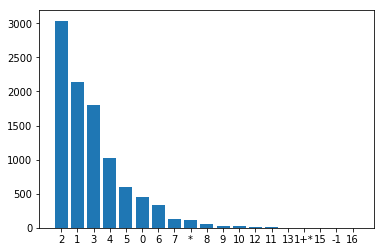

In [78]:
plt.bar(x = df.loc[df['power'] != 'NONE']['power'].value_counts().index, 
         height = df.loc[df['power'] != 'NONE']['power'].value_counts());

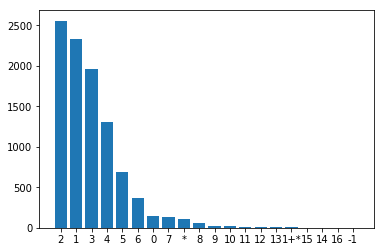

In [79]:
plt.bar(x = df.loc[df['toughness'] != 'NONE']['toughness'].value_counts().index,
        height= df.loc[df['toughness'] != 'NONE']['toughness'].value_counts());

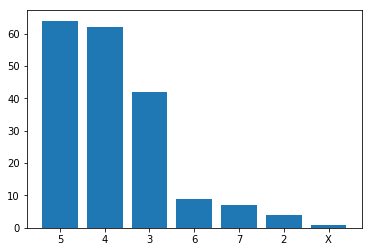

In [80]:
plt.bar(x = df.loc[df['loyalty']!='NONE']['loyalty'].value_counts().index,
        height = df.loc[df['loyalty']!='NONE']['loyalty'].value_counts());

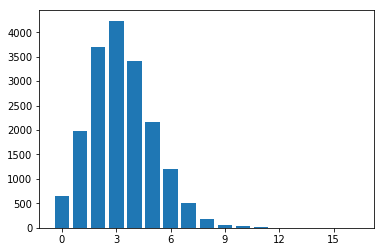

In [81]:
plt.bar(x = df['cmc'].value_counts().index, height=df['cmc'].value_counts());
plt.xticks(ticks=range(0,16,3));

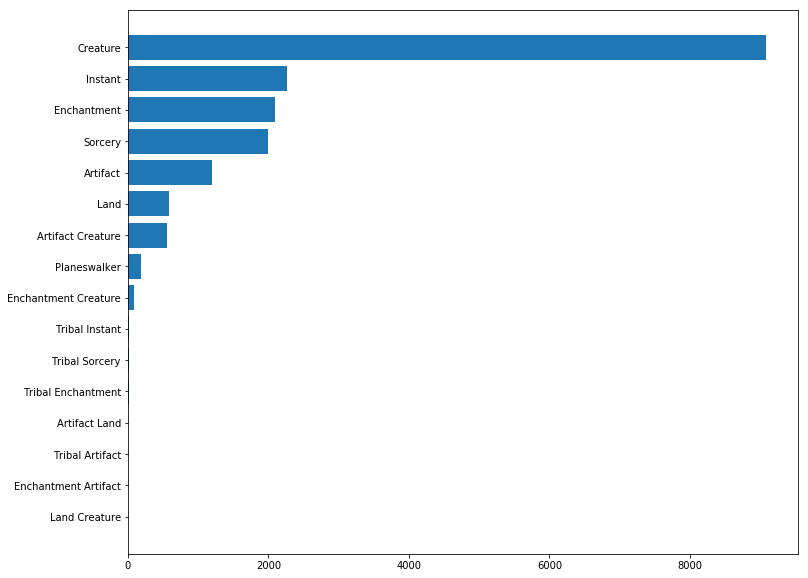

In [82]:
plt.figure(figsize=(12,10))
plt.barh(y=df['card_type'].value_counts().index, width=df['card_type'].value_counts())
plt.gca().invert_yaxis()